In [1]:
# For compatibility across multiple platforms
import os
import numpy as np
import pandas as pd
from scipy import spatial
import gc
import time
import seaborn as sns
import random
random.seed(42)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Load files using DictReader in Python
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import cluster
from sklearn import preprocessing
from sklearn.model_selection import KFold
import sklearn

from ultimate.mlp import MLP 

# from keras.models import Sequential
# from keras.layers import Dropout
# from keras.layers import Dense
# from keras.callbacks import ModelCheckpoint
# from keras.layers import BatchNormalization

In [2]:
train_filepath = "pubg-finish-placement-prediction/train_V2_clean.csv"

#trainset_file = open(train_filepath,'rU')
trainset = pd.read_csv(train_filepath,index_col=0)


/usr/local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
print(len(trainset))

4446965


# Normalization and feature engineering

In [4]:
# partially inspired by https://www.kaggle.com/modmari/deep-neural-network-predicting-pubg-winners
def feature_engineering():
    df = pd.read_csv("pubg-finish-placement-prediction/train_V2_clean.csv",index_col=0)
    df = df[df['maxPlace'] > 1]
 
    df['totalDistance'] = df['rideDistance'] + df["walkDistance"] + df["swimDistance"]
    
    df['rankPoints'] = np.where(df['rankPoints'] <= 0 ,0 , df['rankPoints'])
    
    df['playersJoined'] = df.groupby('matchId')['matchId'].transform('count')
    df['killsNorm'] = df['kills']*((100-df['playersJoined'])/100 + 1)
    df['damageDealtNorm'] = df['damageDealt']*((100-df['playersJoined'])/100 + 1)
    df['maxPlaceNorm'] = df['maxPlace']*((100-df['playersJoined'])/100 + 1)
    df['matchDurationNorm'] = df['matchDuration']*((100-df['playersJoined'])/100 + 1)
    df['healsandboosts'] = df['heals'] + df['boosts']
    df['totalDistance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
    df['killsWithoutMoving'] = ((df['kills'] > 0) & (df['totalDistance'] == 0))
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    df.drop(df[df['killsWithoutMoving'] == True].index, inplace=True)
    df.drop(df[df['roadKills'] > 8].index, inplace=True)
                           
    

    target = 'winPlacePerc'
    # Get a list of the features to be used
    features = list(df.columns)
    
    # Remove some features from the features list :
    features.remove("Id")
    features.remove("matchId")
    features.remove("groupId")
    features.remove("matchDuration")
    features.remove("matchType")
    
    y = None
    
    y = np.array(df.groupby(['matchId','groupId'])[target].agg('mean'), dtype=np.float64)
    # Remove the target from the features list :
    features.remove(target)
    
    # Make new features indicating the mean of the features ( grouped by match and group ) :
    print("get group mean feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('mean')
    # Put the new features into a rank form ( max value will have the highest rank)
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    
    df_out = agg.reset_index()[['matchId','groupId']]
    
    # Merge agg and agg_rank (that we got before) with df_out :
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_mean", "_mean_rank"], how='left', on=['matchId', 'groupId'])
    
    # Make new features indicating the max value of the features for each group ( grouped by match )
    print("get group max feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('max')
    # Put the new features into a rank form ( max value will have the highest rank)
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    # Merge the new (agg and agg_rank) with df_out :
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_max", "_max_rank"], how='left', on=['matchId', 'groupId'])
    
    # Make new features indicating the minimum value of the features for each group ( grouped by match )
    print("get group min feature")
    agg = df.groupby(['matchId','groupId'])[features].agg('min')
    # Put the new features into a rank form ( max value will have the highest rank)
    agg_rank = agg.groupby('matchId')[features].rank(pct=True).reset_index()
    
    # Merge the new (agg and agg_rank) with df_out :
    df_out = df_out.merge(agg.reset_index(), suffixes=["", ""], how='left', on=['matchId', 'groupId'])
    df_out = df_out.merge(agg_rank, suffixes=["_min", "_min_rank"], how='left', on=['matchId', 'groupId'])
    
    # Make new features indicating the number of players in each group ( grouped by match )
    print("get group size feature")
    agg = df.groupby(['matchId','groupId']).size().reset_index(name='group_size')
     
    # Merge the group_size feature with df_out :
    df_out = df_out.merge(agg, how='left', on=['matchId', 'groupId'])
    
    # Make new features indicating the mean value of each features for each match :
    print("get match mean feature")
    agg = df.groupby(['matchId'])[features].agg('mean').reset_index()
    
    # Merge the new agg with df_out :
    df_out = df_out.merge(agg, suffixes=["", "_match_mean"], how='left', on=['matchId'])
    
    # Make new features indicating the number of groups in each match :
    print("get match size feature")
    agg = df.groupby(['matchId']).size().reset_index(name='match_size')
    
    # Merge the match_size feature with df_out :
    df_out = df_out.merge(agg, how='left', on=['matchId'])
    
    # Drop matchId and groupId
    df_out.drop(["matchId", "groupId"], axis=1, inplace=True)
    
    y = y.tolist()
    

    return df_out,y

# Train on XGBoost

In [5]:
#y = trainset["winPlacePerc"]
# x = moddedTrain.drop(columns = ['winPlacePerc'])

x,y = feature_engineering()



processing train_V2.csv
get group mean feature
get group max feature
get group min feature
get group size feature
get match mean feature
get match size feature


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)

In [7]:
x_train.head()

,assists_mean,boosts_mean,damageDealt_mean,DBNOs_mean,headshotKills_mean,heals_mean,killPlace_mean,killPoints_mean,kills_mean,killStreaks_mean,...,totalDistance,playersJoined,killsNorm,damageDealtNorm,maxPlaceNorm,matchDurationNorm,healsandboosts,killsWithoutMoving,headshot_rate,match_size
1999408,0.000000,0.571429,120.811429,1.000000,0.142857,0.714286,41.714286,1285.285714,0.714286,0.714286,...,1010.118761,92.0,1.009565,134.543183,28.08,1396.44,1.978261,False,0.100996,92
228444,0.333333,1.000000,94.003333,0.666667,0.333333,0.000000,30.000000,0.000000,1.000000,1.000000,...,1310.752547,95.0,0.983684,137.225053,28.35,1400.70,2.168421,False,0.130175,95
1275933,0.000000,1.000000,140.200000,0.000000,0.000000,0.000000,25.000000,0.000000,1.000000,1.000000,...,2521.699598,92.0,0.927391,125.854513,99.36,2163.24,2.565217,False,0.097826,92
1626139,0.000000,0.000000,42.300000,0.000000,0.000000,0.000000,90.500000,0.000000,0.000000,0.000000,...,1019.768679,96.0,0.964167,133.303733,50.96,1476.80,2.125000,False,0.087426,96
37849,0.000000,0.000000,58.800000,0.000000,0.000000,0.000000,61.000000,0.000000,0.000000,0.000000,...,2123.007615,96.0,0.953333,129.056417,99.84,2040.48,2.708333,False,0.125446,96


In [8]:
trainset_dmatrix = xgb.DMatrix(x_train.values,label=y_train,feature_names=x_train.columns)
valset_dmatrix = xgb.DMatrix(x_val.values,label=y_val,feature_names=x_val.columns)

In [9]:
params = {
    "max_depth" : 20,
    "eval_metric" : ["mae"],
#     "eta" : 0.1,
     "gamma" : 0.1,
}

In [10]:
clf = xgb.train(params, trainset_dmatrix, evals=[(trainset_dmatrix, "train"),(valset_dmatrix, 'val')], num_boost_round = 10)

#predictions = xgb.predict(valset_dmatrix)

[20:46:35] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 9170 extra nodes, 96200 pruned nodes, max_depth=20
[0]	train-mae:0.183107	val-mae:0.183059
[20:50:37] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 7938 extra nodes, 122264 pruned nodes, max_depth=20
[1]	train-mae:0.130736	val-mae:0.131118
[20:54:42] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6542 extra nodes, 150520 pruned nodes, max_depth=20
[2]	train-mae:0.095021	val-mae:0.09585
[20:58:50] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 5140 extra nodes, 168806 pruned nodes, max_depth=20
[3]	train-mae:0.071183	val-mae:0.072424
[21:03:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4268 extra nodes, 183964 pruned nodes, max_depth=20
[4]	train-mae:0.055703	val-mae:0.057284
[21:07:12] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 3144 extra nodes, 187248 pruned nodes, max_depth=20
[5]	train-mae:0.045861	val-mae:0.047698
[21:11:24] src/tree/updater_prune.cc:74: t

In [ ]:
#best = .031505

# Plot Shap Values for entire dataset

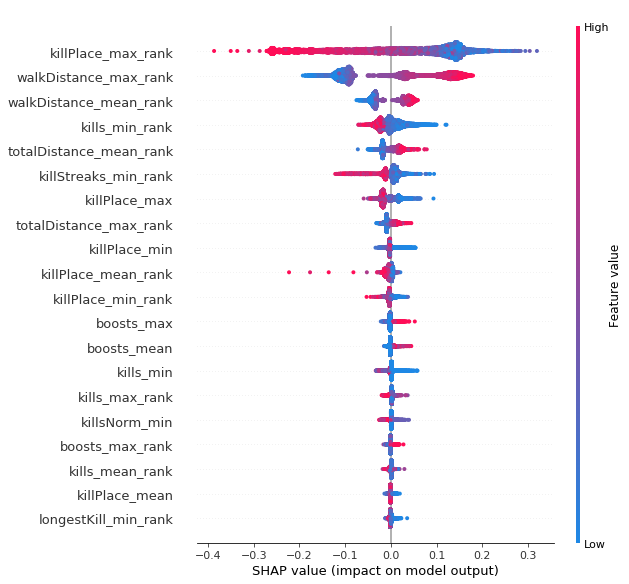

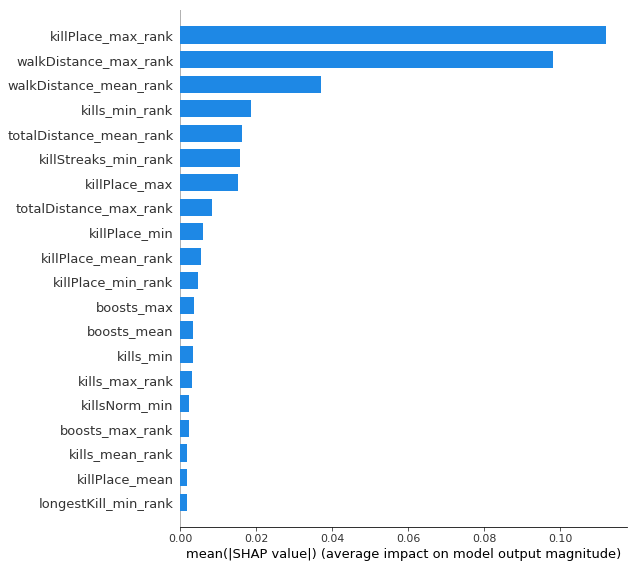

In [11]:
shap_data = x_train.iloc[0:10000,:]
import shap
# load JS visualization code to notebook
shap.initjs()
# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(shap_data)

# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[0,:], shap_data.iloc[0,:])

# summarize the effects of all the features
shap.summary_plot(shap_values, shap_data)

shap.summary_plot(shap_values, shap_data, plot_type="bar")


# NN

In [ ]:
# create NN_model
NN_model = Sequential()
NN_model.add(Dense(x.shape[1],  input_dim = x.shape[1], activation='relu'))
NN_model.add(Dense(50, activation='relu'))
NN_model.add(BatchNormalization())
NN_model.add(Dropout(rate=0.2))
NN_model.add(Dense(50, activation='relu'))
NN_model.add(BatchNormalization())
NN_model.add(Dropout(rate=0.2))
NN_model.add(Dense(50, activation='relu'))






# output Layer
NN_model.add(Dense(1, activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

In [ ]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [ ]:
NN_model.fit(x=x, y=y, batch_size=1000,
             epochs=10, verbose=1, callbacks=callbacks_list,
             validation_split=0.10, validation_data=None, shuffle=True,
             class_weight=None, sample_weight=None, initial_epoch=0,
             steps_per_epoch=None, validation_steps=None)